# Klasyfikacja na danych numerycznych

In [27]:
from IPython.display import display
import pandas as pd

from ium_long_stay_patterns.src.helpers.create_numerical_dataset import create_numerical_dataset, merge_with_stats
from ium_long_stay_patterns.config import ProcessedCSV, ModelParams
from models.binary import BinaryClassifier
from models.naive import NaiveZeroClassifier

import torch
import torch.nn as nn
import torch.optim as optim

from ium_long_stay_patterns.modeling.train import Trainer

from ium_long_stay_patterns.src.helpers.plotting import plot_confusion_matrix

from ium_long_stay_patterns.src.helpers.data_loaders import prepare_and_create_loaders

from ium_long_stay_patterns.config import SAVED_MODELS_DIR, TEST_DATA_DIR

import joblib

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [29]:
df_numeric = create_numerical_dataset(ProcessedCSV.LISTINGS.path, strategy=True)
df_final = merge_with_stats(df_numeric, with_ids=True)

X = df_final.drop(columns=['target', 'id', 'host_id', 'listing_id'])
y = df_final['target']

params = ModelParams()

In [30]:
import json
import numpy as np
import pandas as pd

sel = df_final[df_final['target'] == 1].drop(columns=['target']).head(5)

def _convert(val):
    if pd.isna(val):
        return None
    if isinstance(val, (np.integer,)):
        return int(val)
    if isinstance(val, (np.floating,)):
        return float(val)
    if isinstance(val, (np.bool_,)):
        return bool(val)
    if isinstance(val, np.ndarray):
        return val.tolist()
    return val

records = [{k: _convert(v) for k, v in row.items()} for row in sel.to_dict(orient='records')]
file_path = TEST_DATA_DIR / "test_targets_1.json"
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(records, f, indent=2, ensure_ascii=False)

print(f"Successfully saved {len(records)} records to {file_path}")

Successfully saved 5 records to /home/matimat/IUM/ium-long-stay-patterns/prediction_service/test_data/test_targets_1.json


In [31]:
print(X.columns.tolist())


['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'instant_bookable', 'calculated_host_listings_count', 'reviews_per_month', 'total_bookings']


In [32]:
train_loader, val_loader, test_loader, fitted_scaler = prepare_and_create_loaders(X, y, batch_size=params.batch_size)


Train set size: 875 (239.0 positive)
Validation set size: 219 (60.0 positive)
Test set size: 274
Features: 18
Total positive samples in train set: 239.0


In [33]:
joblib.dump(fitted_scaler, SAVED_MODELS_DIR / "binary_scaler.joblib")

['/home/matimat/IUM/ium-long-stay-patterns/saved_models/binary_scaler.joblib']

## Model setup from best trial in *parameters_tuning.ipynb*

In [34]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
input_dim = images.shape[1]

model = BinaryClassifier(input_dim, params.layers, dropout_rate=params.dropout_rate).to(device)

model


BinaryClassifier(
  (network): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.30000000000000004, inplace=False)
    (3): Linear(in_features=16, out_features=80, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.30000000000000004, inplace=False)
    (6): Linear(in_features=80, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.30000000000000004, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [35]:
criterion = nn.BCELoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=params.learning_rate, 
    weight_decay=params.weight_decay
)

trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    epochs=100
)


In [36]:
trainer.train(train_loader, val_loader)

2026-01-13 19:58:29.102 | INFO     | ium_long_stay_patterns.modeling.train:train:29 - Training started on device: cuda


2026-01-13 19:58:29.337 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 001 | Avg Loss: 0.5424 | AUC: 0.7898 | F1: 0.0000 | P: 0.0000 | R: 0.0000


2026-01-13 19:58:30.900 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 010 | Avg Loss: 0.3723 | AUC: 0.8639 | F1: 0.4842 | P: 0.6571 | R: 0.3833


2026-01-13 19:58:32.848 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 020 | Avg Loss: 0.3406 | AUC: 0.9086 | F1: 0.6667 | P: 0.7500 | R: 0.6000


2026-01-13 19:58:34.747 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 030 | Avg Loss: 0.2916 | AUC: 0.9237 | F1: 0.7091 | P: 0.7800 | R: 0.6500


2026-01-13 19:58:36.584 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 040 | Avg Loss: 0.2512 | AUC: 0.9312 | F1: 0.7769 | P: 0.7705 | R: 0.7833


2026-01-13 19:58:38.329 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 050 | Avg Loss: 0.2459 | AUC: 0.9303 | F1: 0.7934 | P: 0.7869 | R: 0.8000


2026-01-13 19:58:40.186 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 060 | Avg Loss: 0.2072 | AUC: 0.9628 | F1: 0.8067 | P: 0.8136 | R: 0.8000


2026-01-13 19:58:42.349 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 070 | Avg Loss: 0.1890 | AUC: 0.9569 | F1: 0.8403 | P: 0.8475 | R: 0.8333


2026-01-13 19:58:44.337 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 080 | Avg Loss: 0.1769 | AUC: 0.9698 | F1: 0.8276 | P: 0.8571 | R: 0.8000


2026-01-13 19:58:46.155 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 090 | Avg Loss: 0.1998 | AUC: 0.9681 | F1: 0.8305 | P: 0.8448 | R: 0.8167


2026-01-13 19:58:47.940 | INFO     | ium_long_stay_patterns.modeling.train:train:57 - Epoch 100 | Avg Loss: 0.1949 | AUC: 0.9615 | F1: 0.8640 | P: 0.8308 | R: 0.9000


In [37]:
test_metrics = trainer._validate(test_loader)
print(f"Final Test ROC AUC: {test_metrics['auc']:.4f}")
print(f"Final Test F1-Score: {test_metrics['f1']:.4f}")



Final Test ROC AUC: 0.9502
Final Test F1-Score: 0.7871


F1-score jest **wieksze** niz założone w analitycznym kryterium( **0.78** > 0.65).
Roc Auc na poziomie **0.95** oznacza, że model solidnie separuje klasy.

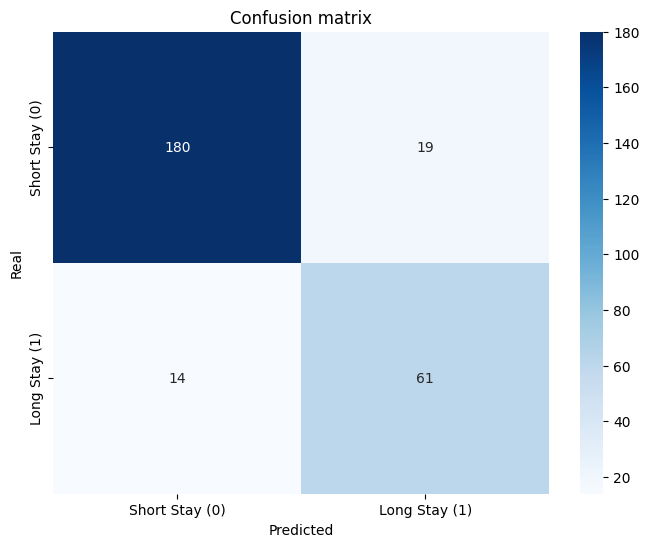


Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92       199
         1.0       0.76      0.81      0.79        75

    accuracy                           0.88       274
   macro avg       0.85      0.86      0.85       274
weighted avg       0.88      0.88      0.88       274



In [38]:
trainer.model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = trainer.model(batch_X.to(trainer.device))
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch_y.numpy())

plot_confusion_matrix(np.array(all_true), np.array(all_preds))

Precyzja dla klasy **long_stay**=1 wynosi 0.76, co dla danych niezbalansowanych jest dość dobrym wynikiem który satysfakcjonuje założone analityczne kryterium sukcesu.

In [39]:
trainer.save_model(SAVED_MODELS_DIR / "binary_classifier_model.pth")

2026-01-13 19:58:48.352 | INFO     | ium_long_stay_patterns.modeling.train:save_model:91 - Model saved to /home/matimat/IUM/ium-long-stay-patterns/saved_models/binary_classifier_model.pth


# Model Naiwny

In [40]:
naive_model = NaiveZeroClassifier()

In [41]:
naive_trainer = Trainer(model=naive_model, criterion=None, optimizer=None)
naive_metrics = naive_trainer._validate(test_loader)

In [42]:
print(f"Final Test ROC AUC: {naive_metrics['auc']:.4f}")
print(f"Final Test F1-Score: {naive_metrics['f1']:.4f}")
print(f"Precision: {naive_metrics['precision']:.4f}")
print(f"Recall:    {naive_metrics['recall']:.4f}")

Final Test ROC AUC: 0.5000
Final Test F1-Score: 0.0000
Precision: 0.0000
Recall:    0.0000


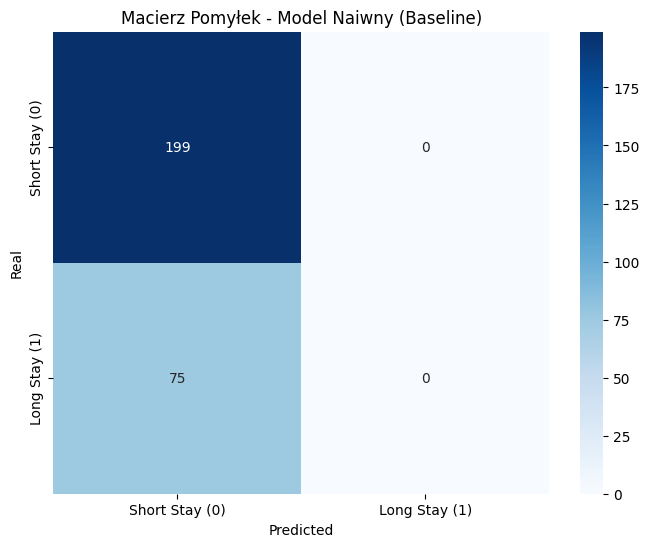


Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84       199
         1.0       0.00      0.00      0.00        75

    accuracy                           0.73       274
   macro avg       0.36      0.50      0.42       274
weighted avg       0.53      0.73      0.61       274



/home/matimat/.cache/pypoetry/virtualenvs/ium-long-stay-patterns-kVcCAgnW-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matimat/.cache/pypoetry/virtualenvs/ium-long-stay-patterns-kVcCAgnW-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matimat/.cache/pypoetry/virtualenvs/ium-long-stay-patterns-kVcCAgnW-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0

In [43]:
all_true = []
all_preds = []

naive_model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = naive_model(batch_X)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(batch_y.numpy())

# Rysowanie macierzy
plot_confusion_matrix(
    np.array(all_true),
    np.array(all_preds),
    title='Macierz Pomyłek - Model Naiwny (Baseline)'
)

In [44]:
trainer.save_model(SAVED_MODELS_DIR / "naive_classifier_model.pth")

2026-01-13 19:58:48.653 | INFO     | ium_long_stay_patterns.modeling.train:save_model:91 - Model saved to /home/matimat/IUM/ium-long-stay-patterns/saved_models/naive_classifier_model.pth


# TODO podsumowanie modeli itp
